In [13]:
import tensorflow as tf 
import os

In [14]:
# Setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

### Removing Dodgy Images

In [16]:
import cv2
import imghdr

In [17]:
data_dir = 'data'

In [18]:
image_exts = ['jpeg','jpg','bmp','png']

In [19]:
image_exts[2]

'bmp'

In [20]:
os.listdir(data_dir)

['happy', 'sad']

In [28]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\happy\depositphotos_391577690-stock-photo-cheerful-woman-outstretched-hands-sitting.jpg
Image not in ext list data\sad\2ef1f06810af48f9a1219d098156eee9.webp
Image not in ext list data\sad\aaxh2l5ni.webp
Image not in ext list data\sad\depositphotos_4584891-stock-photo-sad-man-in-a-empty.jpg
Image not in ext list data\sad\graphics-vect-depression-png-sorry-mom-for-being-rude-clipart-1713885422507.webp
Image not in ext list data\sad\sad-man-and-rain-1330349202VkV.jpg
Image not in ext list data\sad\YZc3LzlASxePQJ_H-iexKQ.webp


### Loading Data

In [32]:
import numpy as np
from matplotlib import pyplot as plt

In [34]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 173 files belonging to 2 classes.


In [36]:
data_iterator = data.as_numpy_iterator()

In [38]:
batch = data_iterator.next()

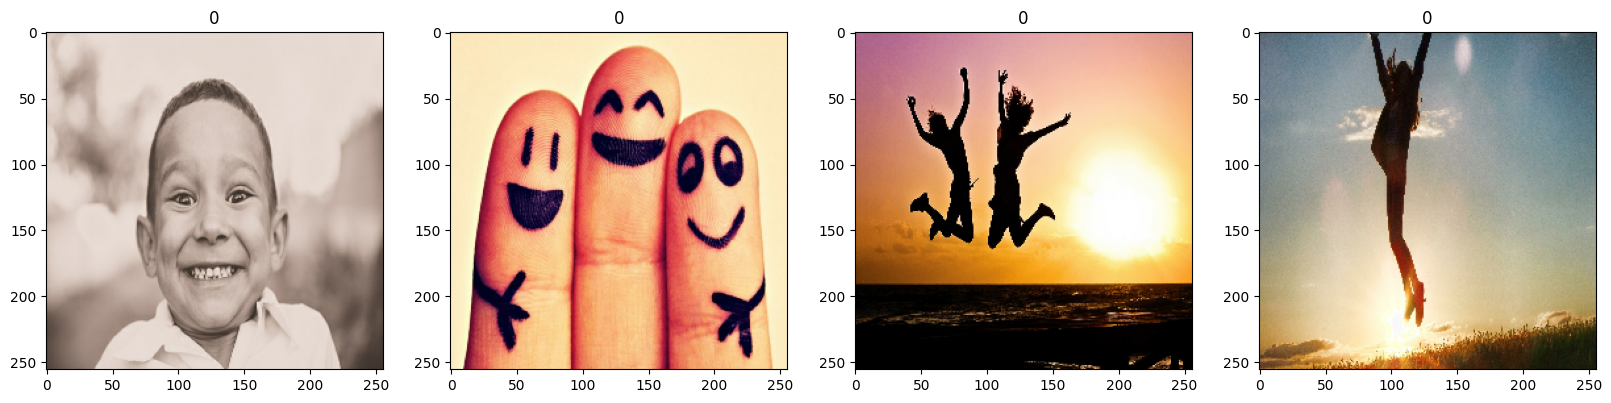

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])